# Loan Data Pre-Processing: Leakage Detection and Prevention

## Overview
This notebook performs pre-processing of the loan data with a focus on identifying and preventing various types of data leakage that could artificially inflate model performance.

## Leakage Types to Monitor

1. Data-Induced Leakage
Label definition that makes prediction trivial (e.g., "Current" status correlates with recent issue dates).

2. Label Leakage
Post-outcome columns such as payments, collections, settlement amounts, or hardship flags that directly reveal the target variable.

3. Preprocessing Leakage
Fitting imputers, scalers, or encoders on the full dataset before train-test split, which leaks information from the test set into training.

4. Split-Related Leakage
Using random split on time-dependent data instead of proper temporal split, allowing future information to leak into training.

5. Data Collecting Leakage
Duplicate records or merged datasets causing the same information to appear in both training and test sets.

6. Synthesis Leakage
Applying SMOTE or oversampling techniques before splitting data, or incorrectly across cross-validation folds.

This test is heavily dependent on resources and information found in this paper: https://arxiv.org/pdf/2401.13796

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

random_for_split = np.random.default_rng(42)

In [3]:
# Resolve paths: data lives at repo root (works on Windows and when run from project_1 or repo root)
_cwd = Path.cwd()
if (_cwd / "data" / "lending-club").exists():
    _root = _cwd
elif (_cwd.parent / "data" / "lending-club").exists():
    _root = _cwd.parent
else:
    _root = _cwd
PROJECT_DIR = _root / "project_1"
ACCEPTED_CSV = _root / "data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv"
assert ACCEPTED_CSV.exists(), f"CSV not found at {ACCEPTED_CSV}"
# SET TO None TO USE FULL DATASET (all 2.26M rows)
MAX_ROWS = None  # None = all rows, or set a number for sampling
FAST_MODE = False
MAX_TRAIN_FIT = None
MAX_TEST_EVAL = None

# Import the full data loader for memory-efficient loading
from full_data_loader import load_full_dataset_chunked, TEXT_COLS, optimize_memory

### In the next cell I dropped text columns for the following reasons:
#### Text columns (desc, emp_title, title) require NLP/text processing.
#### They have high cardinality and high missingness.
#### Using them would require specialized feature engineering (like TF-IDF, embeddings).
#### including these would add complexity and reduce interpretability for a structured-feature baseline.
#### To keep the model simple, interpretable, and leakage-free, we exclude these free-text columns.
#### Risk if kept:
#### Very heavy memory + slower notebooks.
#### Model may learn artifacts or implicit hints about outcomes embedded in text.
#### Decision: drop them for the baseline; consider a separate NLP pipeline later.

In [4]:
from collections import Counter

TEXT_COLS = ["desc", "emp_title", "title"]

print("text columns: cardinality, missingness, example values")

df = pd.read_csv(ACCEPTED_CSV, low_memory=False, nrows=MAX_ROWS)

for col in TEXT_COLS:
    if col not in df.columns:
        continue
    s = df[col]
    n = len(s)
    missing = s.isna().mean() * 100
    nunique = s.nunique(dropna=True)
    print(f"\nColumn: {col}")
    print(f"- Rows: {n:,}")
    print(f"- Missing %: {missing:5.2f}%")
    print(f"- Distinct non-missing: {nunique:,}")
    print("- Example values:")
    print(s.dropna().head(5).tolist())

dropped_cols = [c for c in TEXT_COLS if c in df.columns]
print(f"\nDropped {len(dropped_cols)} text columns: {dropped_cols}")

text columns: cardinality, missingness, example values

Column: desc
- Rows: 2,260,701
- Missing %: 94.42%
- Distinct non-missing: 124,500
- Example values:
['We knew that using our credit cards to finance an adoption would squeeze us, but then medical and other unexpected expenses made the situation almost impossible. We are a stable family in a stable community. We just need to break a cycle of debt that is getting worse.', "I had a bad year two years ago, with some late and missed payments. I'm doing much better now, but I've got fees and some higher interest bits that have added up on top of the other stuff, and it's a little crazy. I'm hoping doing it thru Lending Club will make it easier - and cheaper - to pay off.", "Lenders,  I have the ability to pay off my current debt but, would like the ability to be able to put some extra money off to the side and build my personal savings account.  The lower interest rate of roughly 7% would enable me to do that.  I'm willing to share my 

In [5]:
print("Load accepted dataset with text columns dropped")

# Derive usecols by excluding text columns
all_columns = pd.read_csv(ACCEPTED_CSV, nrows=0).columns.tolist()
usecols = [c for c in all_columns if c not in TEXT_COLS]

if MAX_ROWS is None:
    # FULL DATASET: Use chunked loading with memory optimization
    # This preserves 100% of the data while managing memory efficiently
    print("Loading FULL dataset with chunked processing...")
    df = load_full_dataset_chunked(
        ACCEPTED_CSV,
        chunk_size=200_000,
        usecols=usecols,
        verbose=True
    )
else:
    # SAMPLED: Original sampling approach for faster iteration
    n_total = 0
    for chunk in pd.read_csv(ACCEPTED_CSV, usecols=[usecols[0]], chunksize=100_000, low_memory=False):
        n_total += len(chunk)
    print(f"Total rows in CSV: {n_total:,}")

    keep_indices = {0} | set(
        random_for_split.choice(n_total, size=min(MAX_ROWS, n_total), replace=False) + 1
    )
    df = pd.read_csv(
        ACCEPTED_CSV,
        usecols=usecols,
        low_memory=False,
        skiprows=lambda x: x not in keep_indices,
    )
    df = optimize_memory(df, verbose=True)

print("Shape:", df.shape)
mem_gb = df.memory_usage(deep=True).sum() / (1024**3)
print(f"Approx memory: {mem_gb:.2f} GB")
print(df[["loan_status", "issue_d"]].head(3))

Load accepted dataset with text columns dropped
Loading FULL dataset with chunked processing...
Loading full dataset from /home/wakeb/Wakeb-Projects--1/data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
Chunk size: 200,000 rows
  Loaded 999,988 rows...
  Loaded 1,999,973 rows...
Concatenating 12 chunks...
Memory: 4.13 GB -> 2.47 GB (40.3% reduction)
Total rows loaded: 2,260,668
Final memory usage: 2.47 GB
Shape: (2260668, 148)
Approx memory: 2.47 GB
  loan_status   issue_d
0  Fully Paid  Dec-2015
1  Fully Paid  Dec-2015
2  Fully Paid  Dec-2015


#### Memory usage is a bit high, but I'll go ahead for now. I think my PC can handle it.

In [6]:
print("Raw loan_status distribution (must match summary)")
vc = df["loan_status"].astype("string").value_counts(dropna=False)
print(vc)

print("\nMissing loan_status:", int(df["loan_status"].isna().sum()))

Raw loan_status distribution (must match summary)
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: Int64

Missing loan_status: 0


In [7]:
from cProfile import label


print("Create 3-class target label from loan_status")

STATUS_TO_LABEL = {
    # 0 = fully paid
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    # 1 = charged off / default
    "Charged Off": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
    # 2 = not-final / in-progress
    "Current": 2,
    "Issued": 2,  # likely absent in this file, fine
    "In Grace Period": 2,
    "Late (16-30 days)": 2,
    "Late (31-120 days)": 2,
}

s = df["loan_status"].astype("string").str.strip()
label= s.map(STATUS_TO_LABEL)

print("label missing (loan_status missing):", int(s.isna().sum()))
print("label unmapped (non-missing status not in mapping):", int((s.notna() & label.isna()).sum()))

print("3-class counts (0/1/2)")
print(label.value_counts(dropna=False).sort_index())
print("\nUnmapped statuses (if any):")
print(s[s.notna() & label.isna()].value_counts())

Create 3-class target label from loan_status
label missing (loan_status missing): 0
label unmapped (non-missing status not in mapping): 0
3-class counts (0/1/2)
loan_status
0    1078739
1     269360
2     912569
Name: count, dtype: int64

Unmapped statuses (if any):
Series([], Name: count, dtype: Int64)


### Risk if you continue without acknowledging this:
#### It's true that class 2 is not a final outcome; it’s “not finished yet.” Many of these loans will later become 0 or 1.
#### this creates label noise/censoring and can make models learn “recency” instead of credit risk.
#### I will keep 0/1/2, for now, my reason is: I think it's a bit harsh removing 912,569 entries from the data. That many entries means that when the model makes predictions, it will encounter these people a lot. Excluding them may result in model drift.

In [8]:
issue_dt = pd.to_datetime(df["issue_d"].astype("string").str.strip(), format="%b-%Y", errors="coerce")
tmp = pd.DataFrame({"issue_d": issue_dt, "label": label})

tmp["issue_year"] = tmp["issue_d"].dt.year
by_year = (
    tmp.dropna(subset=["issue_year", "label"])
       .groupby(["issue_year", "label"])
       .size()
       .unstack(fill_value=0)
       .sort_index()
)
display(by_year.tail(15))

share2 = (by_year[2] / by_year.sum(axis=1)).rename("share_class2")
display(share2.tail(15))

label,0,1,2
issue_year,,,
2007,445,158,0
2008,1897,496,0
2009,4558,723,0
2010,10780,1757,0
2011,18424,3297,0
2012,44723,8644,0
2013,113780,21024,10
2014,181941,41162,12526
2015,299742,75804,45549


issue_year
2007    0.000000
2008    0.000000
2009    0.000000
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.000074
2014    0.053160
2015    0.108168
2016    0.325276
2017    0.618284
2018    0.886282
Name: share_class2, dtype: float64

##### Data-induced leakage check (is class 2 mostly “recent issue date”?):
#### Risk if you continue are:
#### If class 2 ≈ recent years, then any time-correlated feature (even legitimate origination features) can make the task artificially easy.
#### Random split will overestimate performance because train/test share the same time regimes.
#### Decision
#### Always compare random split vs time split.
#### Consider excluding issue_year/issue_month features and see how much performance drops (if huge, the task is dominated by time/censoring).

In [9]:
print("Duplicate checks (data-collecting leakage risk)")
if "id" in df.columns:
    n = len(df)
    nunique = df["id"].nunique(dropna=True)
    miss = df["id"].isna().sum()
    print({"rows": n, "unique_id": int(nunique), "missing_id": int(miss), "dup_rows_est": int(n - miss - nunique)})
else:
    print("No id column found")

# Row-level duplicates on a stable subset (avoid huge text columns)
subset_cols = [c for c in df.columns if c not in {"url"}][:40]  # keep it light
dups = df.duplicated(subset=subset_cols, keep=False).sum()
print("Row-dup count (subset-based):", int(dups))

Duplicate checks (data-collecting leakage risk)
{'rows': 2260668, 'unique_id': 2260668, 'missing_id': 0, 'dup_rows_est': 0}
Row-dup count (subset-based): 0


In [10]:
print("Top missingness columns (overall)")
miss = df.isna().mean().sort_values(ascending=False)
display((miss.head(30) * 100).to_frame("missing_pct"))

print("Missingness by class (top differences)")
check_cols = [c for c in df.columns if c not in {"loan_status"}]

rows = []
for c in check_cols:
    m = []
    for k in [0,1,2]:
        m.append(df.loc[label==k, c].isna().mean()*100)
    rows.append({"col": c, "miss0": m[0], "miss1": m[1], "miss2": m[2], "max_diff": max(m)-min(m)})

miss_by_class = pd.DataFrame(rows).sort_values("max_diff", ascending=False)
display(miss_by_class.head(30))

Top missingness columns (overall)


,missing_pct
member_id,100.000000
orig_projected_additional_accrued_interest,99.617325
hardship_end_date,99.517090
hardship_start_date,99.517090
hardship_type,99.517090
hardship_reason,99.517090
hardship_status,99.517090
deferral_term,99.517090
hardship_last_payment_amount,99.517090
hardship_payoff_balance_amount,99.517090


Missingness by class (top differences)


,col,miss0,miss1,miss2,max_diff
45,next_pymnt_d,99.815711,99.702628,0.000000,99.815711
73,inq_last_12m,61.297496,55.399465,6.099922,55.197574
72,total_cu_tl,61.297496,55.399465,6.099922,55.197574
59,open_acc_6m,61.297496,55.399465,6.099922,55.197574
71,inq_fi,61.297404,55.399465,6.099922,55.197481
67,open_rv_24m,61.297404,55.399465,6.099922,55.197481
66,open_rv_12m,61.297404,55.399465,6.099922,55.197481
64,total_bal_il,61.297404,55.399465,6.099922,55.197481
62,open_il_24m,61.297404,55.399465,6.099922,55.197481
61,open_il_12m,61.297404,55.399465,6.099922,55.197481


#### Risk if you continue
#### If class-specific missingness is extreme, models can predict by “is NaN” rather than real signal.
#### Also, if you compute imputation stats on the full dataset, that’s preprocessing leakage.
#### Decision
#### Use pipelines that fit imputers/encoders only on train.
#### Consider dropping ultra-missing columns (e.g., ≥95% missing) or keeping with caution.

In [11]:
print("Leakage columns present (post-origination/performance/hardship/settlement)")
from pipeline.config import LeakageSpec, iter_leakage_columns

leakage_cols = sorted(iter_leakage_columns(all_columns, LeakageSpec()))
present_leakage_cols = [c for c in leakage_cols if c in df.columns]

print("Leakage columns detected (by rules):", len(present_leakage_cols))
print("Examples:", present_leakage_cols[:30])

Leakage columns present (post-origination/performance/hardship/settlement)
Leakage columns detected (by rules): 43
Examples: ['collection_recovery_fee', 'debt_settlement_flag', 'debt_settlement_flag_date', 'deferral_term', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_status', 'member_id', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'out_prncp', 'out_prncp_inv', 'payment_plan_start_date', 'policy_code']


#### Risk if you continue
#### Columns like total_pymnt, recoveries, out_prncp, last_pymnt_*, settlement_*, hardship_* often encode the outcome directly.
#### Including them can yield “too good to be true” metrics that won’t exist at prediction time.
#### Decision: keep them only for audit/EDA, drop from model features.

In [12]:
print("Build clean vs leaky-probe feature frames")

# Keep only rows with mapped y3
keep = label.notna()
df_kept = df.loc[keep].copy()
label_kept = label.loc[keep].astype(int)

# CLEAN FEATURES: drop leakage + raw loan_status + url (id-like)
drop_for_clean = set(present_leakage_cols) | {"loan_status"}
df_clean = df_kept.drop(columns=[c for c in drop_for_clean if c in df_kept.columns], errors="ignore")

# LEAKY PROBE FEATURES: keep ONLY leakage columns (demonstrate label leakage)
leaky_probe_cols = [c for c in present_leakage_cols if c in df_kept.columns]
df_leaky = df_kept[leaky_probe_cols].copy()

print("df_clean shape:", df_clean.shape)
print("df_leaky shape:", df_leaky.shape)
print("label classes:", label_kept.value_counts().sort_index().to_dict())

Build clean vs leaky-probe feature frames
df_clean shape: (2260668, 105)
df_leaky shape: (2260668, 43)
label classes: {0: 1078739, 1: 269360, 2: 912569}


#### Risk if you continue
#### If performance/hardship/settlement features remain in df_clean, your leakage test is invalid.
#### Decision: print and manually inspect any suspicious columns remaining; extend the drop rules if needed.

In [13]:
from pipeline.clean import parse_month_year

print("Create time split based on issue_d (and compare to random split)")
issue_dt = parse_month_year(df_kept["issue_d"])
df_clean2 = df_clean.copy()
df_clean2["issue_d_dt"] = issue_dt

# Time split cutoff
cutoff = df_clean2["issue_d_dt"].dropna().quantile(0.8)
time_train = df_clean2["issue_d_dt"] <= cutoff
time_test  = df_clean2["issue_d_dt"] >  cutoff

# Random split
idx = np.arange(len(df_clean2))
random_for_split.shuffle(idx)
split = int(len(idx)*0.8)
rand_train_idx = idx[:split]
rand_test_idx = idx[split:]

def show_split_stats(name, train_mask, test_mask):
    print(f"Split stats: {name}")
    print("Train rows:", int(train_mask.sum()), "Test rows:", int(test_mask.sum()))
    print("Train class dist:", label_kept[train_mask].value_counts(normalize=True).sort_index().round(3).to_dict())
    print("Test class dist :", label_kept[test_mask].value_counts(normalize=True).sort_index().round(3).to_dict())

show_split_stats("TIME", time_train.values, time_test.values)

# For random split we use index arrays
rand_train_mask = np.zeros(len(df_clean2), dtype=bool); rand_train_mask[rand_train_idx] = True
rand_test_mask  = np.zeros(len(df_clean2), dtype=bool); rand_test_mask[rand_test_idx] = True
show_split_stats("RANDOM", rand_train_mask, rand_test_mask)

Create time split based on issue_d (and compare to random split)
Split stats: TIME
Train rows: 1834519 Test rows: 426149
Train class dist: {0: 0.569, 1: 0.144, 2: 0.287}
Test class dist : {0: 0.082, 1: 0.014, 2: 0.904}
Split stats: RANDOM
Train rows: 1808534 Test rows: 452134
Train class dist: {0: 0.477, 1: 0.119, 2: 0.404}
Test class dist : {0: 0.478, 1: 0.119, 2: 0.404}


#### Risk if you continue
#### If random split looks “great” but time split degrades, you were relying on time regime similarity.
#### Decision: report time-split metrics as primary; optionally use rolling time splits.

In [14]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, log_loss
)
from pipeline.config import CleaningSpec
from pipeline.clean import basic_clean_inplace
from pipeline.features import infer_feature_types
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data

cleaning_spec = CleaningSpec()

def make_sklearn_ready(X: pd.DataFrame):
    X = X.copy()
    # basic_clean_inplace is in-place and expects some LC columns; safe to call on X+issue_d separately if needed
    return X

def eval_multiclass(y_true, y_pred, y_proba=None):
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }
    if y_proba is not None:
        out["log_loss"] = log_loss(y_true, y_proba, labels=[0,1,2])
    return out

def fit_eval(X_train, y_train, X_test, y_test, label):
    # Infer feature types
    num_cols, cat_cols = infer_feature_types(X_train)
    
    # Train using memory-optimized function (native CatBoost Pool + GPU)
    model = train_catboost_memory_optimized(
        X_train.copy(), y_train,  
        X_test.copy(), y_test,
        numeric_cols=num_cols,
        categorical_cols=cat_cols
    )

    # Preprocess test data
    X_test_prep = prepare_catboost_data(X_test, num_cols, cat_cols)
    
    y_pred = model.predict(X_test_prep)
    y_proba = model.predict_proba(X_test_prep)
    metrics = eval_multiclass(y_test, y_pred, y_proba=y_proba)

    return {
        "label": label,
        **metrics,
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=[0,1,2]),
        "report": classification_report(y_test, y_pred, digits=3),
    }


#### Replaced the RAM-heavy Sklearn pipeline with a custom function (train_catboost_memory_optimized)
#### that loads data into CatBoost's efficient "Pool" format and immediately deletes the source DataFrames to prevent crashes.

###### for more reading: https://catboost.ai/docs/en/concepts/python-reference_pool

In [ ]:
# Define MAX_TRAIN_FIT if not already defined
import subprocess
if 'MAX_TRAIN_FIT' not in globals():
    MAX_TRAIN_FIT = None  # Default value for stratified downsampling

print("Prepare clean matrices for TIME split")
X = df_clean2.drop(columns=["issue_d_dt"], errors="ignore")
X_time_train = X.loc[time_train].copy()
X_time_test = X.loc[time_test].copy()
y_time_train = label_kept.loc[time_train].values
y_time_test = label_kept.loc[time_test].values

print("Prepare clean matrices for RANDOM split")
X_rand_train = X.loc[rand_train_mask].copy()
X_rand_test = X.loc[rand_test_mask].copy()
y_rand_train = label_kept.loc[rand_train_mask].values
y_rand_test = label_kept.loc[rand_test_mask].values

# LEAKY probe matrices (TIME split)
Xl = df_leaky.copy()
Xl_time_train = Xl.loc[time_train].copy()
Xl_time_test  = Xl.loc[time_test].copy()

results = []
results.append(fit_eval(X_time_train, y_time_train, X_time_test, y_time_test, label="CLEAN + TIME"))
results.append(fit_eval(X_rand_train, y_rand_train, X_rand_test, y_rand_test, label="CLEAN + RANDOM"))
results.append(fit_eval(Xl_time_train, y_time_train, Xl_time_test, y_time_test, label="LEAKY_PROBE + TIME"))

summary = pd.DataFrame([{k:v for k,v in r.items() if k not in {"confusion_matrix","report"}} for r in results])
display(summary.sort_values("f1_macro", ascending=False))

gpu_info = subprocess.getoutput('nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader 2>&1 || echo "nvidia-smi not available"')
print(f"gpu: {gpu_info}")


for r in results:
    print(r["label"])
    print("Metrics:", {k: r[k] for k in ["accuracy","balanced_acc","f1_macro","f1_weighted","log_loss"] if k in r})
    print("Confusion matrix [rows=true, cols=pred] for labels [0,1,2]:\n", r["confusion_matrix"])
    print("\nClassification report:\n", r["report"])

Prepare clean matrices for TIME split
Prepare clean matrices for RANDOM split
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 1.0761126	test: 1.1421831	best: 1.1421831 (0)	total: 15.2ms	remaining: 15.2s
bestTest = 1.142183146
bestIteration = 0
Shrink model to first 1 iterations.
Training complete!


/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 1.0715514	test: 1.0714445	best: 1.0714445 (0)	total: 15.8ms	remaining: 15.8s
100:	learn: 0.7575738	test: 0.7560256	best: 0.7560256 (100)	total: 1.5s	remaining: 13.3s
200:	learn: 0.7453091	test: 0.7442765	best: 0.7442765 (200)	total: 2.93s	remaining: 11.7s
300:	learn: 0.7404327	test: 0.7399748	best: 0.7399748 (300)	total: 4.31s	remaining: 10s
400:	learn: 0.7373230	test: 0.7374762	best: 0.7374762 (400)	total: 5.67s	remaining: 8.47s
500:	learn: 0.7350988	test: 0.7358043	best: 0.7358043 (500)	total: 7.03s	remaining: 7s
600:	learn: 0.7332729	test: 0.7345941	best: 0.7345941 (600)	total: 8.46s	remaining: 5.62s
700:	learn: 0.7317308	test: 0.7336024	best: 0.7336024 (700)	total: 9.88s	remaining: 4.21s
800:	learn: 0.7303691	test: 0.7327871	best: 0.7327

,label,accuracy,balanced_acc,f1_macro,f1_weighted,log_loss
2,LEAKY_PROBE + TIME,1.000000,1.000000,1.000000,1.000000,0.000002
1,CLEAN + RANDOM,0.659057,0.649869,0.606569,0.678288,0.711287
0,CLEAN + TIME,0.065564,0.411636,0.064972,0.012718,1.139601


gpu: NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB, 15364 MiB
CLEAN + TIME
Metrics: {'accuracy': 0.0655639224778188, 'balanced_acc': 0.4116359647791863, 'f1_macro': 0.06497232549675275, 'f1_weighted': 0.012717720038702111, 'log_loss': 1.1396013524613553}
Confusion matrix [rows=true, cols=pred] for labels [0,1,2]:
 [[ 24840  10242      0]
 [  2784   3100      0]
 [276784 108399      0]]

Classification report:
               precision    recall  f1-score   support

           0      0.082     0.708     0.146     35082
           1      0.025     0.527     0.049      5884
           2      0.000     0.000     0.000    385183

    accuracy                          0.066    426149
   macro avg      0.036     0.412     0.065    426149
weighted avg      0.007     0.066     0.013    426149

CLEAN + RANDOM
Metrics: {'accuracy': 0.6590568282854198, 'balanced_acc': 0.6498692951170258, 'f1_macro': 0.6065688496445564, 'f1_weighted': 0.6782884172784351, 'log_loss': 0.7112868535554647}
Confusion matri

#### If CLEAN + RANDOM >> CLEAN + TIME → split-related (temporal) leakage risk. Prefer time split reporting.
#### If LEAKY_PROBE + TIME is near-perfect → label leakage exists in the raw dataset (expected). This validates why those columns must be dropped.
#### If clean performance is high only when issue_year/month are included → data-induced/censoring dominance (class 2 is basically "recent").

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from pipeline.features import infer_feature_types
from IPython.display import display

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def get_audit_matrix(df, name, target_series):
    # 1. Setup
    cols_to_drop = [c for c in ['issue_d_dt', 'issue_d', 'loan_status'] if c in df.columns]
    X = df.drop(columns=cols_to_drop)
    num_cols, cat_cols = infer_feature_types(X)
    y = target_series.loc[X.index]
    
    m0, m1, m2 = y==0, y==1, y==2

    # 2. NUMERIC
    num_data = []
    for col in num_cols:
        try:
            v0, v1, v2 = X.loc[m0, col].dropna(), X.loc[m1, col].dropna(), X.loc[m2, col].dropna()
            
            def get_t(a, b): return abs(ttest_ind(a, b, equal_var=False)[0]) if len(a)>10 and len(b)>10 else 0
            
            num_data.append({
                "Feature": col,
                "Good vs Bad (0v1)": get_t(v0, v1),
                "Cur vs Bad (2v1)": get_t(v2, v1),
                "Cur vs Good (2v0)": get_t(v2, v0),
            })
        except: pass
    
    df_num = pd.DataFrame(num_data).set_index("Feature")
    df_num["Max T"] = df_num.max(axis=1)
    df_num = df_num.sort_values("Max T", ascending=False)

    # 3. CATEGORICAL
    cat_data = []
    y_str = y.astype(str)
    for col in cat_cols:
        try:
            cat_data.append({
                "Feature": col,
                "Cramér V": cramers_v(X[col].astype(str), y_str)
            })
        except: pass
    
    df_cat = pd.DataFrame(cat_data).set_index("Feature").sort_values("Cramér V", ascending=False)

    # DISPLAY
    print(f"\nAUDIT MATRIX: {name}")
    
    # Style numeric: Red for T > 50
    s_num = df_num.style.background_gradient(cmap='Reds', subset=["Max T"], vmin=0, vmax=100)\
                  .format("{:.1f}")\
                  .set_caption(f"Numeric Leakage Audit (Top 20 of {len(df_num)})")
    display(s_num)

    # Style categorical: Red for V > 0.8
    s_cat = df_cat.style.background_gradient(cmap='Reds', vmin=0, vmax=1)\
                  .format("{:.4f}")\
                  .set_caption(f"Categorical Association (All {len(df_cat)})")
    display(s_cat)

# EXECUTE
s_idx = df_clean2.sample(min(100000, len(df_clean2)), random_state=42).index
t_sample = label_kept.loc[s_idx]

get_audit_matrix(df_clean2.loc[s_idx], "CLEAN DATASET", t_sample)
get_audit_matrix(df_leaky.loc[s_idx], "LEAKY DATASET", t_sample)


AUDIT MATRIX: CLEAN DATASET


,Good vs Bad (0v1),Cur vs Bad (2v1),Cur vs Good (2v0),Max T
Feature,,,,
int_rate,61.7,55.2,7.0,61.7
fico_range_high,36.7,48.8,17.4,48.8
fico_range_low,36.7,48.8,17.4,48.8
bc_open_to_buy,21.7,35.9,19.2,35.9
inq_last_6mths,13.6,31.7,31.8,31.8
percent_bc_gt_75,16.7,31.0,22.3,31.0
total_bc_limit,17.5,30.7,18.6,30.7
num_bc_tl,3.2,16.4,30.5,30.5
bc_util,16.4,29.9,20.7,29.9


,Cramér V
Feature,
initial_list_status,0.2562
disbursement_method,0.1950
application_type,0.1843
term,0.1812
sub_grade,0.1654
grade,0.1609
earliest_cr_line,0.1332
sec_app_earliest_cr_line,0.1267
verification_status_joint,0.1259


/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:592: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



AUDIT MATRIX: LEAKY DATASET


,Good vs Bad (0v1),Cur vs Bad (2v1),Cur vs Good (2v0),Max T
Feature,,,,
out_prncp,1.3,251.8,252.3,252.3
out_prncp_inv,1.3,251.7,252.2,252.2
last_fico_range_high,237.7,237.6,3.2,237.7
total_rec_prncp,177.7,25.2,179.0,179.0
last_pymnt_amnt,178.7,4.4,179.0,179.0
total_pymnt,106.0,3.2,138.2,138.2
total_pymnt_inv,105.9,2.9,137.7,137.7
last_fico_range_low,107.6,108.4,0.8,108.4
recoveries,71.5,71.5,nan,71.5


,Cramér V
Feature,
url,inf
next_pymnt_d,0.7073
last_pymnt_d,0.6782
last_credit_pull_d,0.5230
debt_settlement_flag,0.3246
settlement_status,0.2297
settlement_date,0.2293
debt_settlement_flag_date,0.2288
hardship_type,0.0667


In [16]:
# --- EXPERIMENT: MODERN DATA + DETAILED LABELS (FIXED V4) ---
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report
from pipeline.clean import parse_month_year

print("Filtering to Modern Era (2014-2018)...")

# 1. Force issue_d to Datetime
df_clean2['issue_d'] = parse_month_year(df_clean2['issue_d'].astype(str))

# 2. Filter 2014+
modern_mask = df_clean2['issue_d'].dt.year >= 2014
df_modern = df_clean2.loc[modern_mask].copy()
df_modern['issue_d'] = pd.to_datetime(df_modern['issue_d'])

# Sync labels
labels_modern_raw = df["loan_status"].loc[df_modern.index]

print(f"Original Row Count: {len(df_clean2):,}")
print(f"Modern Row Count:   {len(df_modern):,}")

# 3. Engineer 4-Class Target
def get_detailed_label(status):
    s = str(status).strip()
    if s in ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]:
        return 0 # Good
    elif s in ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]:
        return 1 # Bad
    elif "Late" in s or "In Grace Period" in s:
        return 2 # Late/Warning
    elif s in ["Current", "Issued"]:
        return 3 # Current
    return -1

y_modern = labels_modern_raw.apply(get_detailed_label)
valid_mask = y_modern != -1
df_modern = df_modern.loc[valid_mask]
y_modern = y_modern.loc[valid_mask]

# Get actual unique labels present in data
unique_labels = sorted(y_modern.unique())
print(f"Final Count: {len(df_modern):,}")
print(f"Labels Present: {unique_labels}")
print(f"Distribution: {y_modern.value_counts().sort_index().to_dict()}")

# 4. Retrain
issue_dt_modern = df_modern['issue_d']
cutoff_modern = issue_dt_modern.quantile(0.8)
train_mask_mod = issue_dt_modern <= cutoff_modern
test_mask_mod = issue_dt_modern > cutoff_modern

cols_drop = ["issue_d", "loan_status", "issue_d_dt"]
X = df_modern.drop(columns=cols_drop, errors="ignore")

X_mod_train = X.loc[train_mask_mod].copy()
X_mod_test = X.loc[test_mask_mod].copy()
y_mod_train = y_modern.loc[train_mask_mod].values
y_mod_test = y_modern.loc[test_mask_mod].values

print("\nTraining on 4-Class Modern Target...")

# --- DYNAMIC EVALUATION FUNCTION OVERRIDE ---
def eval_multiclass_dynamic(y_true, y_pred, y_proba=None):
    # Dynamically handle whatever classes are present
    classes = np.unique(y_true)
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }
    if y_proba is not None:
        # Use classes from y_true for log_loss
        out["log_loss"] = log_loss(y_true, y_proba, labels=classes)
    return out

# Manually running training loop here to use the dynamic eval
num_cols, cat_cols = infer_feature_types(X_mod_train)
model = train_catboost_memory_optimized(
    X_mod_train.copy(), y_mod_train,
    X_mod_test.copy(), y_mod_test,
    numeric_cols=num_cols, categorical_cols=cat_cols
)

X_test_prep = prepare_catboost_data(X_mod_test, num_cols, cat_cols)
y_pred = model.predict(X_test_prep)
y_proba = model.predict_proba(X_test_prep)

# Evaluate
metrics = eval_multiclass_dynamic(y_mod_test, y_pred, y_proba=y_proba)
cm = confusion_matrix(y_mod_test, y_pred, labels=unique_labels)
cr = classification_report(y_mod_test, y_pred, digits=3, labels=unique_labels)

print("\n" + "="*60)
print(f"Metrics: {metrics}")
print("Classification Report")
print("="*60)
print(cr)
print("\nConfusion Matrix:")
print(cm)

Filtering to Modern Era (2014-2018)...
Original Row Count: 2,260,668
Modern Row Count:   2,029,952
Final Count: 2,029,952
Labels Present: [0, 1, 2, 3]
Distribution: {0: 884132, 1: 233261, 2: 34248, 3: 878311}

Training on 4-Class Modern Target...
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 1.3671645	test: 1.3641387	best: 1.3641387 (0)	total: 19.1ms	remaining: 19.1s
100:	learn: 1.1482224	test: 1.0536148	best: 1.0536148 (100)	total: 1.67s	remaining: 14.9s
200:	learn: 1.1339872	test: 1.0321247	best: 1.0321017 (198)	total: 3.17s	remaining: 12.6s
300:	learn: 1.1245017	test: 1.0207155	best: 1.0206564 (295)	total: 4.65s	remaining: 10.8s
400:	learn: 1.1169979	test: 1.0159546	best: 1.0157961 (394)	total: 6.1s	remaining: 9.12s
500:	learn: 1.1112724	test: 1.0124857	best: 1.0124857 (500)	total: 7

In [18]:
# --- EXPERIMENT: RANDOM SPLIT (MODERN 4-CLASS) - FIXED V2 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report
import numpy as np
from pipeline.features import infer_feature_types
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data

print("Running RANDOM SPLIT on Modern Data (2014-2018)...")

# 1. Split (Stratified to keep class ratios)
X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(
    X, y_modern, test_size=0.2, random_state=42, stratify=y_modern
)

print(f"Train Size: {len(X_rand_train):,}")
print(f"Test Size:  {len(X_rand_test):,}")
print("\nTraining on 4-Class Target (RANDOM SPLIT)...")

# 2. Train (Inline logic to handle 4 classes correctly)
num_cols, cat_cols = infer_feature_types(X_rand_train)

model_rand = train_catboost_memory_optimized(
    X_rand_train.copy(), y_rand_train, 
    X_rand_test.copy(), y_rand_test,
    numeric_cols=num_cols, categorical_cols=cat_cols
)

# 3. Predict including dynamic labels
X_test_prep = prepare_catboost_data(X_rand_test, num_cols, cat_cols)
y_pred = model_rand.predict(X_test_prep)
y_proba = model_rand.predict_proba(X_test_prep)

# 4. Evaluate (Dynamic Labels Logic Inline - SAME FIX)
unique_labels = sorted(list(set(y_modern))) # [0, 1, 2, 3]

# Calculate metrics safely
metrics = {
    "accuracy": accuracy_score(y_rand_test, y_pred),
    "balanced_acc": balanced_accuracy_score(y_rand_test, y_pred),
    "f1_macro": f1_score(y_rand_test, y_pred, average="macro"),
    "f1_weighted": f1_score(y_rand_test, y_pred, average="weighted"),
    # Use explicit unique labels for log loss to avoid mismatch
    "log_loss": log_loss(y_rand_test, y_proba, labels=unique_labels) 
}

print("\n" + "="*60)
print(f"Metrics: {metrics}")
print("Classification Report (RANDOM SPLIT)")
print("="*60)
print(classification_report(y_rand_test, y_pred, digits=3, labels=unique_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(y_rand_test, y_pred, labels=unique_labels))

Running RANDOM SPLIT on Modern Data (2014-2018)...
Train Size: 1,623,961
Test Size:  405,991

Training on 4-Class Target (RANDOM SPLIT)...
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 1.3659794	test: 1.3658554	best: 1.3658554 (0)	total: 16.5ms	remaining: 16.5s
100:	learn: 1.1260442	test: 1.1260247	best: 1.1260247 (100)	total: 1.54s	remaining: 13.8s
200:	learn: 1.1082558	test: 1.1105909	best: 1.1105909 (200)	total: 2.96s	remaining: 11.8s
300:	learn: 1.0953553	test: 1.1000888	best: 1.1000888 (300)	total: 4.35s	remaining: 10.1s
400:	learn: 1.0852162	test: 1.0923578	best: 1.0923578 (400)	total: 5.79s	remaining: 8.65s
500:	learn: 1.0767121	test: 1.0859495	best: 1.0859495 (500)	total: 7.22s	remaining: 7.19s
600:	learn: 1.0696790	test: 1.0812575	best: 1.0812575 (600)	total: 8.67s	remaining: 5

In [19]:
# --- EXPERIMENT: 3-CLASS (PAID vs DEFAULT vs LATE) - NO CURRENT ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report
import numpy as np
from pipeline.features import infer_feature_types
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data
from pipeline.clean import parse_month_year

print("Filtering to Modern Era (2014-2018)... Dropping 'Current'...")

# 1. Force issue_d to Datetime
df_clean2['issue_d'] = parse_month_year(df_clean2['issue_d'].astype(str))

# 2. Filter 2014+
modern_mask = df_clean2['issue_d'].dt.year >= 2014
df_modern = df_clean2.loc[modern_mask].copy()
labels_modern_raw = df["loan_status"].loc[df_modern.index]

# 3. Engineer 3-Class Target (Drop Current)
# 0: Good, 1: Bad, 2: Late
def get_3class_label(status):
    s = str(status).strip()
    if s in ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]:
        return 0 # Good
    elif s in ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]:
        return 1 # Bad
    elif "Late" in s or "In Grace Period" in s:
        return 2 # Late/Warning
    # Drop Current/Issued
    return -1

y_no_current = labels_modern_raw.apply(get_3class_label)
valid_mask = y_no_current != -1
df_3class = df_modern.loc[valid_mask].copy()
y_3class = y_no_current.loc[valid_mask]

# Double check issue_d time 
df_3class['issue_d'] = pd.to_datetime(df_3class['issue_d'])

print(f"Final Count (No Current): {len(df_3class):,}")
print(f"Labels: 0=Paid, 1=Default, 2=Late")
print(f"Distribution: {y_3class.value_counts().sort_index().to_dict()}")

# 4. TIME SPLIT
issue_dt_3class = df_3class['issue_d']
cutoff_3class = issue_dt_3class.quantile(0.8)
train_mask = issue_dt_3class <= cutoff_3class
test_mask = issue_dt_3class > cutoff_3class

X = df_3class.drop(columns=["issue_d", "loan_status", "issue_d_dt"], errors="ignore")
X_train = X.loc[train_mask].copy()
X_test = X.loc[test_mask].copy()
y_train = y_3class.loc[train_mask].values
y_test = y_3class.loc[test_mask].values

print(f"\nTrain Size: {len(X_train):,}")
print(f"Test Size:  {len(X_test):,}")
print("\nTraining on 3-Class Target (No Current)...")

# 5. Train
num_cols, cat_cols = infer_feature_types(X_train)
model_3c = train_catboost_memory_optimized(
    X_train.copy(), y_train, 
    X_test.copy(), y_test,
    numeric_cols=num_cols, categorical_cols=cat_cols
)

# 6. Predict
X_test_prep = prepare_catboost_data(X_test, num_cols, cat_cols)
y_pred = model_3c.predict(X_test_prep)
y_proba = model_3c.predict_proba(X_test_prep)

# 7. Evaluate
ulabels = sorted(list(set(y_3class)))
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_acc": balanced_accuracy_score(y_test, y_pred),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    "log_loss": log_loss(y_test, y_proba, labels=ulabels) 
}

print("\n" + "="*60)
print(f"Metrics (3-Class Time Split): {metrics}")
print("Classification Report")
print("="*60)
print(classification_report(y_test, y_pred, digits=3, labels=ulabels))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=ulabels))

Filtering to Modern Era (2014-2018)... Dropping 'Current'...
Final Count (No Current): 1,151,641
Labels: 0=Paid, 1=Default, 2=Late
Distribution: {0: 884132, 1: 233261, 2: 34248}

Train Size: 933,174
Test Size:  218,467

Training on 3-Class Target (No Current)...
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 1.0831491	test: 1.0782277	best: 1.0782277 (0)	total: 12ms	remaining: 12s
100:	learn: 0.8899255	test: 0.8093843	best: 0.8093843 (100)	total: 955ms	remaining: 8.5s
bestTest = 0.8084151311
bestIteration = 107
Shrink model to first 108 iterations.
Training complete!

Metrics (3-Class Time Split): {'accuracy': 0.3057715810625861, 'balanced_acc': 0.40284661628625246, 'f1_macro': 0.23973057963164202, 'f1_weighted': 0.3463994672334773, 'log_loss': 1.2151909720872196}
Classification Report
  

In [20]:
# --- FINAL EXPERIMENT: BINARY OUTCOME MODEL (PAID vs DEFAULT) ---
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report
from pipeline.features import infer_feature_types
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data
from pipeline.clean import parse_month_year

print("Building PRODUCTION Binary Model (2014-2018)...")

# 1. Filter to Modern Era & Outcomes ONLY
df_clean2['issue_d'] = parse_month_year(df_clean2['issue_d'].astype(str))
modern_mask = df_clean2['issue_d'].dt.year >= 2014
df_modern = df_clean2.loc[modern_mask].copy()
labels_raw = df["loan_status"].loc[df_modern.index]

# 0: Fully Paid, 1: Default/Charged Off
def get_binary_label(status):
    s = str(status).strip()
    if s in ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]:
        return 0 
    elif s in ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"]:
        return 1
    return -1 # Skip Current, Late, Grace Period

y_binary = labels_raw.apply(get_binary_label)
valid = y_binary != -1
df_bin = df_modern.loc[valid].copy()
y_bin = y_binary.loc[valid]

print(f"Outcome Samples: {len(df_bin):,}")
print(f"Class Dist: {y_bin.value_counts(normalize=True).to_dict()}")

# 2. TIME SPLIT (80/20)
df_bin['issue_d'] = pd.to_datetime(df_bin['issue_d'])
cutoff = df_bin['issue_d'].quantile(0.8)
train_mask = df_bin['issue_d'] <= cutoff
test_mask = df_bin['issue_d'] > cutoff

X = df_bin.drop(columns=["issue_d", "loan_status", "issue_d_dt"], errors="ignore")
X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y_bin.loc[train_mask].values, y_bin.loc[test_mask].values

print(f"Train Size: {len(X_train):,} | Test Size: {len(X_test):,}")

# 3. Train Memory-Optimized CatBoost
num_cols, cat_cols = infer_feature_types(X_train)
model_bin = train_catboost_memory_optimized(
    X_train.copy(), y_train, X_test.copy(), y_test,
    numeric_cols=num_cols, categorical_cols=cat_cols
)

# 4. Predict
X_test_prep = prepare_catboost_data(X_test, num_cols, cat_cols)
y_pred = model_bin.predict(X_test_prep)
y_proba = model_bin.predict_proba(X_test_prep)

# 5. Evaluate
print("\n" + "="*60)
print("BINARY MODEL PERFORMANCE (TEST SET)")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Acc: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=["Paid(0)", "Default(1)"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Building PRODUCTION Binary Model (2014-2018)...
Outcome Samples: 1,117,393
Class Dist: {0: 0.7912453362424858, 1: 0.20875466375751414}
Train Size: 908,149 | Test Size: 209,244
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 0.6858166	test: 0.6866679	best: 0.6866679 (0)	total: 28.5ms	remaining: 28.5s
100:	learn: 0.6063549	test: 0.6182327	best: 0.6182327 (100)	total: 1s	remaining: 8.95s
200:	learn: 0.6022797	test: 0.6133812	best: 0.6133407 (199)	total: 1.98s	remaining: 7.87s
300:	learn: 0.5997507	test: 0.6107828	best: 0.6107828 (300)	total: 2.95s	remaining: 6.85s
400:	learn: 0.5977248	test: 0.6088740	best: 0.6088740 (400)	total: 3.93s	remaining: 5.87s
500:	learn: 0.5960368	test: 0.6075129	best: 0.6075129 (500)	total: 4.92s	remaining: 4.9s
600:	learn: 0.5945534	test: 0.6064996	best: 0.606499

Scoring high-risk 'Current' loans...

Top 10 'Current' loans with highest Risk Score (Likely to Default):


,predicted_risk_score
2152196,0.965271
617733,0.961718
2176498,0.958915
2060327,0.957857
1081733,0.956724
1685655,0.952496
2167514,0.951498
2226146,0.951179
505072,0.950803
1963548,0.949931


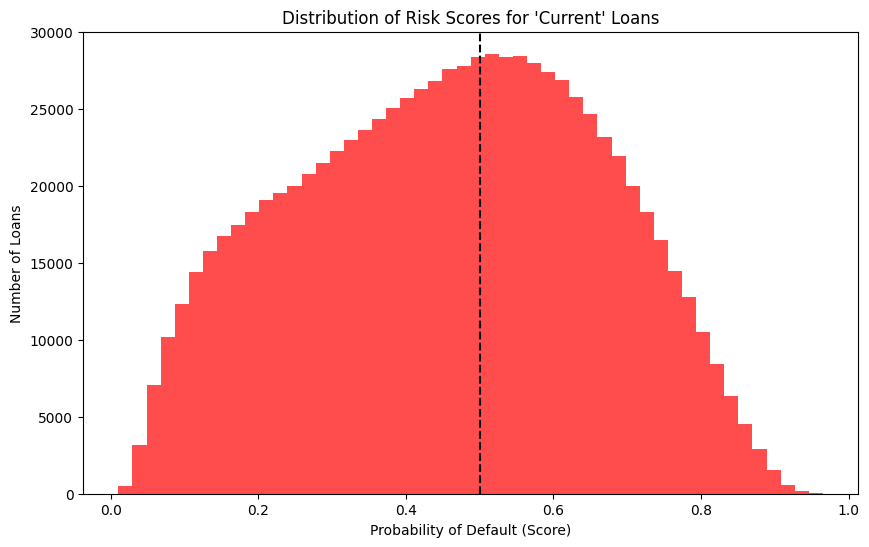

Total Current Loans: 878,311
Total labeled 'High Risk' (>0.5): 390,484 (44.5%)


In [23]:
# --- STEP 6: RISK SCORING FOR CURRENT LOANS ---

print("Scoring high-risk 'Current' loans...")

# 1. Isolate the 'Current' loans that were excluded from training
current_mask = labels_raw.apply(lambda x: str(x).strip() in ["Current", "Issued"])
df_current = df_modern.loc[current_mask].copy()

# 2. Preprocess Current Data
X_curr = df_current.drop(columns=["issue_d", "loan_status", "issue_d_dt"], errors="ignore")
X_curr_prep = prepare_catboost_data(X_curr, num_cols, cat_cols)

# 3. Predict Probabilities (Probability of Default)
# Class 1 is 'Default', so column index 1 is the Risk Score
risk_scores = model_bin.predict_proba(X_curr_prep)[:, 1]

# 4. Attach scores back to the data
df_current['predicted_risk_score'] = risk_scores

# 5. Show Top 10 High-Risk 'Current' Loans
print("\nTop 10 'Current' loans with highest Risk Score (Likely to Default):")
display(df_current[['predicted_risk_score']].sort_values('predicted_risk_score', ascending=False).head(10))

# 6. Risk Distribution Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(risk_scores, bins=50, color='red', alpha=0.7)
plt.title("Distribution of Risk Scores for 'Current' Loans")
plt.xlabel("Probability of Default (Score)")
plt.ylabel("Number of Loans")
plt.axvline(0.5, color='black', linestyle='--') # Standard threshold
plt.show()

high_risk_count = (risk_scores > 0.5).sum()
print(f"Total Current Loans: {len(df_current):,}")
print(f"Total labeled 'High Risk' (>0.5): {high_risk_count:,} ({high_risk_count/len(df_current):.1%})")

#### Wrap-up
#### — Final "leakage audit" conclusions you should write
#### What target means (snapshot 0/1/2 vs final-outcome default).
#### Which leakage types were detected (and evidence from experiment cells).
#### What you dropped (post-origination columns list).
#### What split you use (time split as primary).
#### What preprocessing rule you enforce (fit-on-train only).
#### Next step recommendation: either keep 3-class for snapshot task, or switch to a horizon-based binary default task.
#### If you want, tell me which objective you truly want:
#### A) predict eventual default (binary, final outcomes), or
#### B) predict status at dataset snapshot (3-class),
#### and I'll tailor the "decision" cells (especially the data-induced leakage ones) to match that objective exactly.